In [1]:
from torch import nn, optim
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torchvision.models import swin_t, Swin_T_Weights
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from dataset_preparation import get_data  # Assuming this is a custom function for loading data
from torch.amp import GradScaler, autocast


In [2]:
train_loader, val_loader, test_loader, classes_weights = get_data(batch_size=32,workers=8)


In [3]:
classes_weights

,Class,Count,Weight
0,n02085620-Chihuahua,111,0.009009
1,n02085782-Japanese_spaniel,137,0.007299
2,n02085936-Maltese_dog,181,0.005525
3,n02086079-Pekinese,109,0.009174
4,n02086240-Shih-Tzu,153,0.006536
...,...,...,...
116,n02113978-Mexican_hairless,110,0.009091
117,n02115641-dingo,115,0.008696
118,n02115913-dhole,107,0.009346
119,n02116738-African_hunting_dog,118,0.008475


Epoch 1/50 - Validation: 100%|██████████| 101/101 [00:33<00:00,  2.97it/s]


Epoch 1/50: Train Loss: 1.3248, Val Loss: 0.4091, Train Acc: 0.7942, Val Acc: 0.8951


Epoch 2/50 - Validation: 100%|██████████| 101/101 [00:33<00:00,  3.01it/s]


Epoch 2/50: Train Loss: 0.3804, Val Loss: 0.3274, Train Acc: 0.9062, Val Acc: 0.9050


Epoch 3/50 - Validation: 100%|██████████| 101/101 [00:33<00:00,  3.00it/s]


Epoch 3/50: Train Loss: 0.3124, Val Loss: 0.3204, Train Acc: 0.9146, Val Acc: 0.8967


Epoch 4/50 - Validation: 100%|██████████| 101/101 [00:33<00:00,  3.03it/s]


Epoch 4/50: Train Loss: 0.2630, Val Loss: 0.3026, Train Acc: 0.9260, Val Acc: 0.9025


Epoch 5/50 - Validation: 100%|██████████| 101/101 [00:35<00:00,  2.88it/s]


Epoch 5/50: Train Loss: 0.2312, Val Loss: 0.3084, Train Acc: 0.9356, Val Acc: 0.8988


Epoch 6/50 - Validation: 100%|██████████| 101/101 [00:34<00:00,  2.97it/s]


Epoch 6/50: Train Loss: 0.1800, Val Loss: 0.3104, Train Acc: 0.9449, Val Acc: 0.9097


Epoch 7/50 - Validation: 100%|██████████| 101/101 [00:33<00:00,  3.01it/s]


Epoch 7/50: Train Loss: 0.1360, Val Loss: 0.3296, Train Acc: 0.9595, Val Acc: 0.9093


Epoch 8/50 - Validation: 100%|██████████| 101/101 [00:36<00:00,  2.80it/s]


Epoch 8/50: Train Loss: 0.1132, Val Loss: 0.3484, Train Acc: 0.9675, Val Acc: 0.9078


Epoch 9/50 - Validation: 100%|██████████| 101/101 [00:34<00:00,  2.97it/s]


Epoch 9/50: Train Loss: 0.0956, Val Loss: 0.3682, Train Acc: 0.9724, Val Acc: 0.9066


Epoch 10/50 - Validation: 100%|██████████| 101/101 [00:35<00:00,  2.84it/s]


Epoch 10/50: Train Loss: 0.0859, Val Loss: 0.3661, Train Acc: 0.9750, Val Acc: 0.9053


Epoch 11/50 - Validation: 100%|██████████| 101/101 [00:35<00:00,  2.82it/s]


Epoch 11/50: Train Loss: 0.0804, Val Loss: 0.3647, Train Acc: 0.9778, Val Acc: 0.9069


Epoch 12/50 - Validation: 100%|██████████| 101/101 [00:33<00:00,  3.00it/s]


Epoch 12/50: Train Loss: 0.0753, Val Loss: 0.3640, Train Acc: 0.9785, Val Acc: 0.9072


Epoch 13/50 - Validation: 100%|██████████| 101/101 [00:33<00:00,  3.01it/s]


Epoch 13/50: Train Loss: 0.0713, Val Loss: 0.3668, Train Acc: 0.9798, Val Acc: 0.9066


Epoch 14/50 - Validation: 100%|██████████| 101/101 [00:33<00:00,  3.02it/s]


Epoch 14/50: Train Loss: 0.0673, Val Loss: 0.3688, Train Acc: 0.9816, Val Acc: 0.9087
Early stopping triggered.


Testing: 100%|██████████| 101/101 [00:33<00:00,  3.02it/s]


Test Accuracy: 0.9053


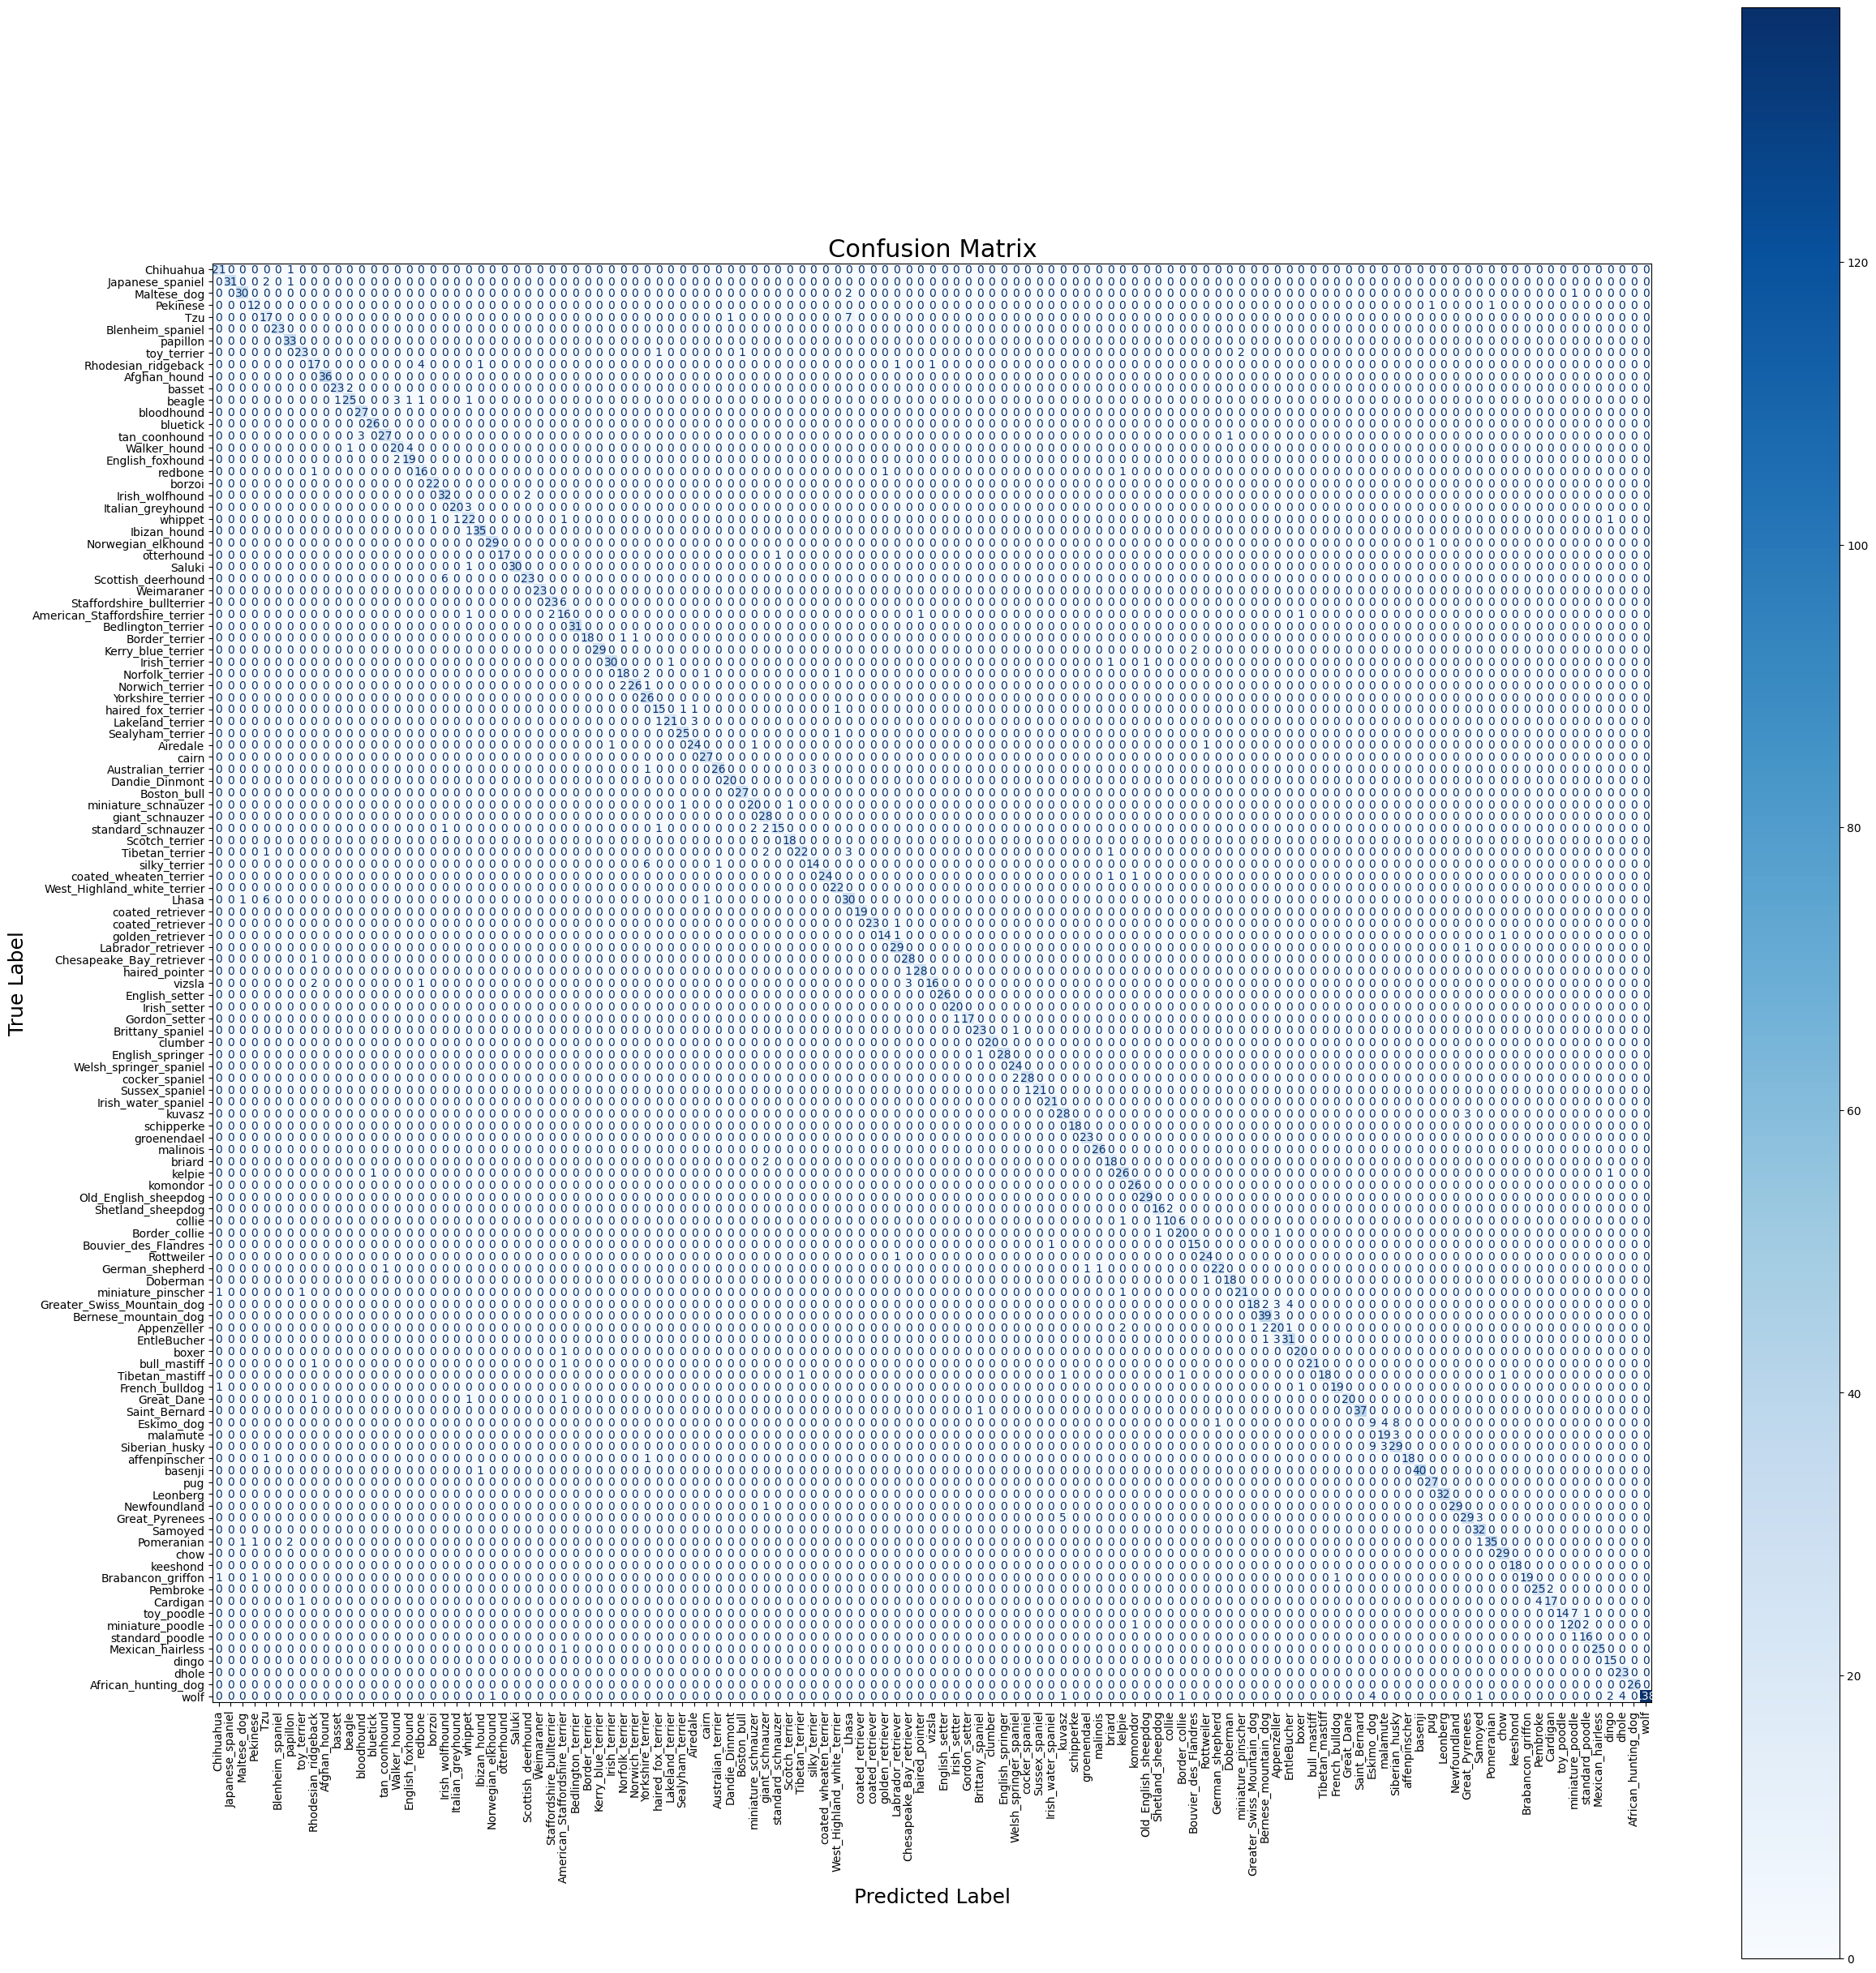

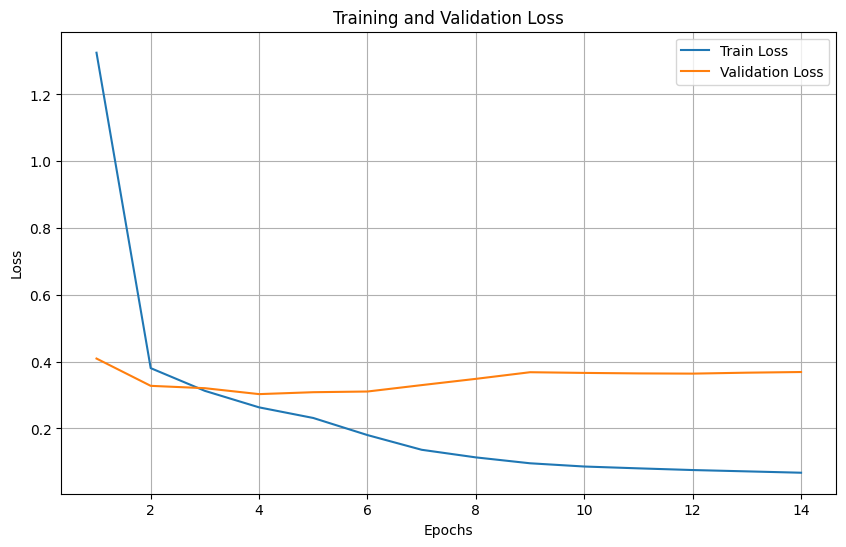

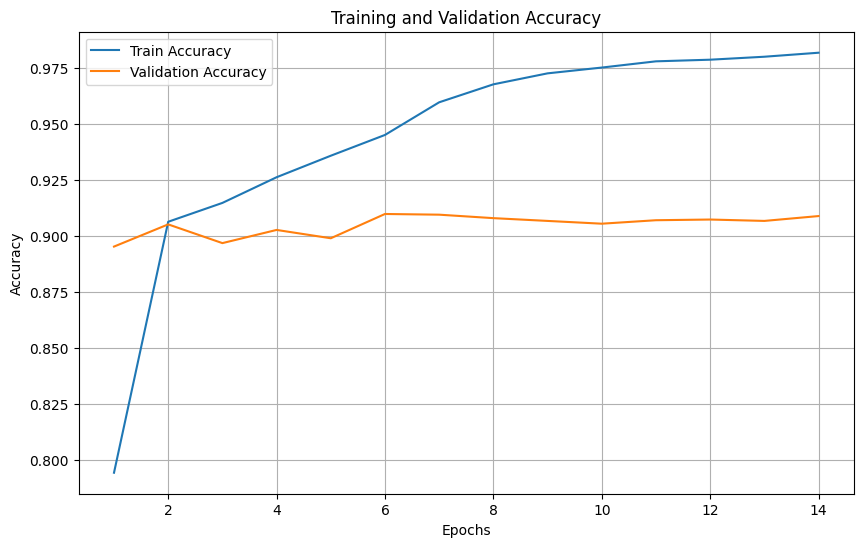

In [4]:

# Load data
train_loader, val_loader, test_loader, classes_weights = get_data(batch_size=32,workers=8)

# Define device
device = torch.device("cuda")
classes_weights = torch.tensor(classes_weights['Weight'].values, dtype=torch.float32).to(device)

# Model setup
num_classes = len(train_loader.dataset.dataset.classes)  # Access the underlying dataset
model = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)
model.head = nn.Linear(in_features=model.head.in_features, out_features=num_classes)
model = model.to(device)

# Freeze backbone initially
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True


# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=classes_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

scaler = GradScaler()  # GradScaler for scaling gradients during mixed precision training

# Training setup
epochs = 50
patience, early_stop_counter = 10, 0
best_val_loss = float('inf')
best_model_path = "best_model.pth"

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
initial_phase_epochs = 5
# Training and validation loop
for epoch in range(epochs):
    
    if epoch == initial_phase_epochs:
        for param in model.parameters():
            param.requires_grad = True

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # Lower LR for fine-tuning
        
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    
    
    model.train()
    train_loss, train_correct,total = 0.0, 0,0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)  # Step optimizer with scaled gradients
        scaler.update()  # Update the scaler for the next iteration

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = train_correct / total
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss, val_correct,total = 0.0, 0,0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = val_correct / total
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Learning rate adjustment
    scheduler.step(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    print(f"Epoch {epoch + 1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early stopping
    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# Load the best model for testing
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()

# Testing phase
test_correct, all_preds, all_labels,total = 0, [], [],0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        test_correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)

test_accuracy = test_correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


original_classes = train_loader.dataset.dataset.classes
processed_classes = [cls.split('-')[-1] for cls in original_classes]  # Use only the part after the last '-'



cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(25, 25))  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=processed_classes)
disp.plot(ax=ax, cmap="Blues")

ax.set_xticks(np.arange(num_classes))
ax.set_xticklabels(processed_classes, rotation=90, fontsize=8)  
ax.set_yticks(np.arange(num_classes))
ax.set_yticklabels(processed_classes, fontsize=8)

plt.title("Confusion Matrix", fontsize=22)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()



# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()



# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

